In [1]:
import numpy as np
import pandas as pd
import os
import pickle
import re

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, show
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import statsmodels.api as sm

In [ ]:
os.chdir("C:/Users/peter/OneDrive - University of East Anglia/UEA/blog/covid")

df=pd.read_csv('data.csv')
#df.to_csv('conference_carbon.csv')
for col in  df.columns[2:]:
    df[col] = pd.to_numeric(df[col], errors='coerce')
df['sum']=df.sum(numeric_only=True,axis=1)
df_pop=pd.read_csv('pop_data.csv')
df_pop=df_pop.rename(columns={'Area code': 'Area Code'})
df=pd.merge(df,df_pop,on='Area Code',how="left")
df.rename(columns={ df.columns[-1]: "population" }, inplace = True)
df.rename(columns={ df.columns[-2]: "final_period" }, inplace = True)
df['population']=df['population'].str.replace(r'\D+', '').astype(float)
df['inf_rate']=df['final_period']/(df['population']/1000)
cum=df.iloc[:,2:27] # change here if data is updated
cum=cum.cumsum(axis = 1)
cum2=cum.div((df['population']/1000), axis=0)
df['toone']=(len(cum2.columns)-cum2.eq(0).sum(axis=1)-cum2.ge(1).sum(axis=1))#*(-1) # multiply by -1 to measure speed rather than slowness
cum2=cum.div((df['population']/1000), axis=0)
df['onetotwo']=cum2.ge(1).sum(axis=1)-cum2.gt(2).sum(axis=1)
df.loc[df['onetotwo']==0,'onetotwo']=np.nan


#exp_para0=[]
exp_para1=[]
exp=df.iloc[:,2:27] # change here if data is updated
exp=np.log(exp)
X=list(range(0,len(exp.columns)))
#X = sm.add_constant(X)

for i in range(1,len(exp.index)):
    y = exp.iloc[i,:]
    y=y.reset_index()
    y=y.iloc[:,1]
    y=y.replace([np.inf, -np.inf], np.nan)
    model = sm.OLS(y,X,missing='drop')
    results = model.fit()
    #para0=results.params[0]
    para1=results.params[0]
    #exp_para0.append(para0)
    exp_para1.append(para1)
    
#exp_para0=pd.DataFrame(exp_para0)
exp_para1=pd.DataFrame(exp_para1)
#exp_para0.columns= ["exp_para0"]
exp_para1.columns= ["exp_para1"]
#exp_para0=exp_para0.rename(columns={'0': 'exp_para0'})
exp_para1=exp_para1.rename(columns={'0': 'exp_para1'})
#df=pd.concat([df,exp_para0,exp_para1],axis=1)
df=pd.concat([df,exp_para1],axis=1)


df.to_pickle('data')

# Age

In [9]:
os.chdir("C:/Users/peter/OneDrive - University of East Anglia/UEA/blog/covid")

df=pd.read_pickle('data')
df_age=pd.read_csv('age_data.csv')
df_age=df_age.rename(columns={'Area code': 'Area Code'})
df_age.loc[df_age['Area Code'] =='E06000048', 'Area Code'] = "E06000057"
df_age.loc[df_age['Area Code'] =='E06000028', 'Area Code'] = "E06000058"
df_age.loc[df_age['Area Code'] =='E10000009', 'Area Code'] = "E06000059"
df_age.loc[df_age['Area Code'] =='E08000020', 'Area Code'] = "E08000037"
df_age = df_age.replace(',','', regex=True)
columns=df_age.columns
columns=columns[1:]
df_age[columns] = df_age[columns].apply(pd.to_numeric, errors='coerce')

df1=pd.merge(df,df_age,on='Area Code',how="left")

corrs=df1.iloc[:,29:]
ctable1=corrs.corr()
res1=ctable1.iloc[5:,[0,1,3]]
#res1.reset_index(level=0, inplace=True)
#res1=res1.iloc[3:,:]

res1a=res1.iloc[:,0]
corrs1a=corrs.iloc[:,5:]

#res1.columns=['infection/1000 people','number of days to reach 1/1000','exponential parameter']
#res1=res1.round(3)
ctable1a=ctable1.iloc[5:,:4]
ctable1a

,inf_rate,toone,onetotwo,exp_para1
Age 0 to 4,0.390907,-0.356921,-0.038318,-0.033424
Age 5 to 7,0.153062,-0.221400,-0.066381,-0.051477
Age 8 to 9,0.005636,-0.094399,-0.042102,-0.034884
Age 10 to 14,-0.349197,0.101905,-0.068065,-0.064806
Age 15,-0.480042,0.124534,-0.102755,-0.093056
Age 16 to 17,-0.482659,0.128234,-0.082065,-0.074387
Age 18 to 19,-0.138674,0.019796,0.081897,-0.120810
Age 20 to 24,0.283461,-0.233323,0.050716,-0.068370
Age 25 to 29,0.704897,-0.483825,-0.034258,0.036686
Age 30 to 44,0.765208,-0.512327,0.065240,0.092188


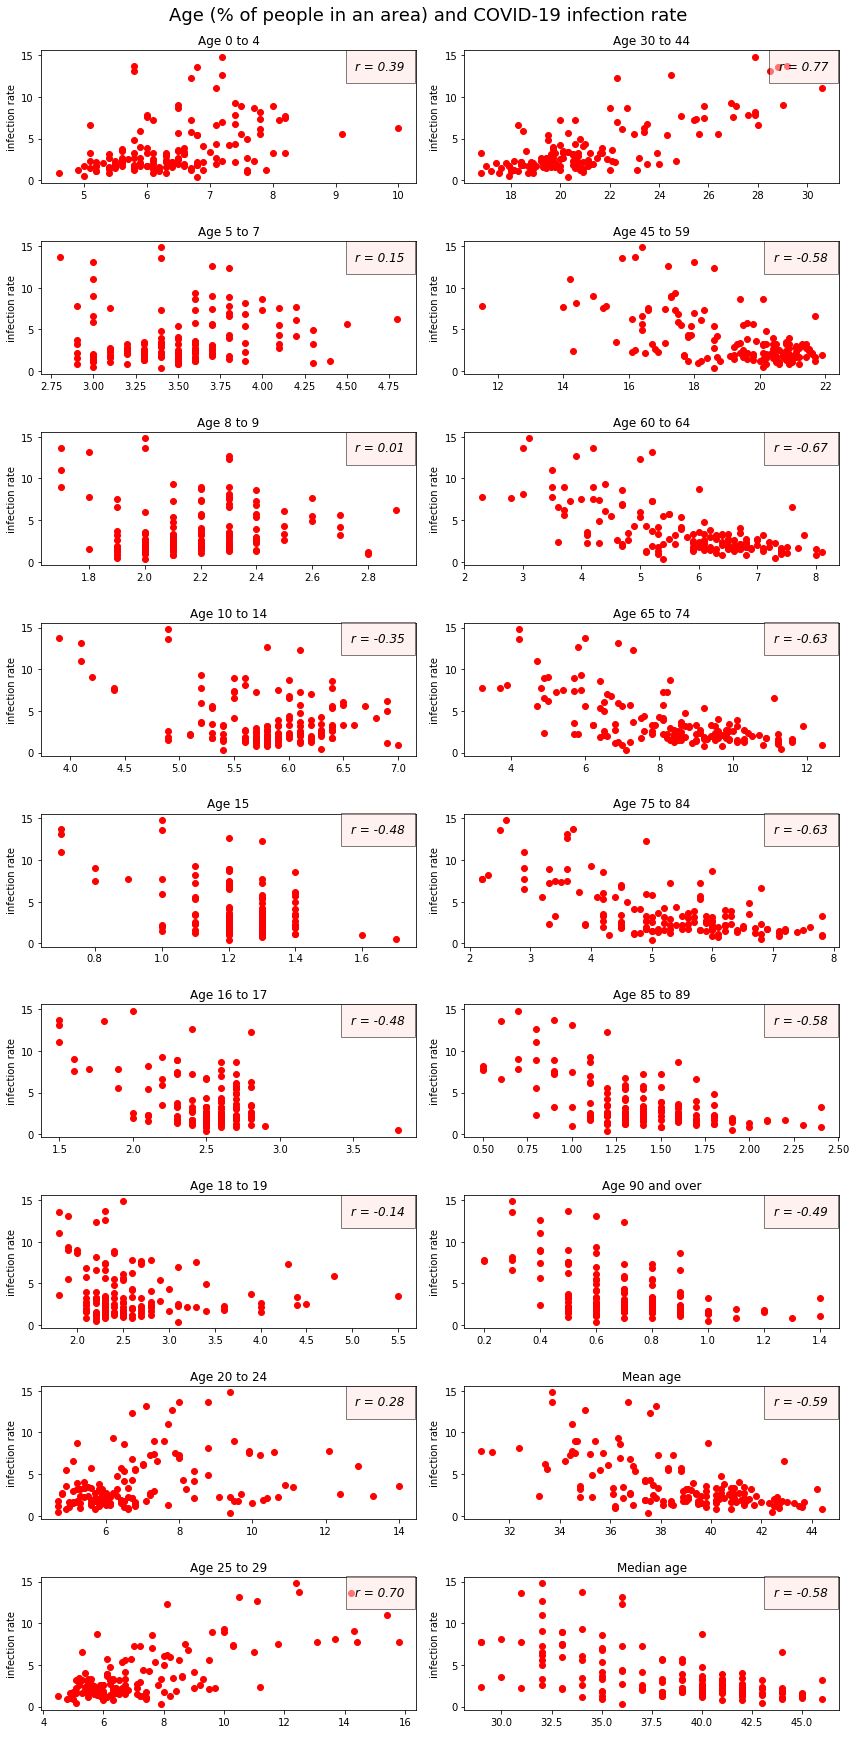

In [10]:
fig, axs = plt.subplots(9, 2, figsize = (12,24))
fig.suptitle('Age (% of people in an area) and COVID-19 infection rate',y=1.01,fontsize=18)

for i,col in enumerate(corrs1a.columns):
    if i<=8:
        axs[i, 0].scatter(corrs1a[col], corrs["inf_rate"],c='red')
        axs[i, 0].set_title(str(res1a.index[i]))
        axs[i, 0].annotate("r = {:.2f}".format(res1a[i]), xy=(0.97, 0.83), xycoords='axes fraction', fontsize=12,style='italic',
                horizontalalignment='right', verticalalignment='bottom',bbox={'facecolor': 'mistyrose', 'alpha': 0.5, 'pad': 10})
    else:
        axs[i-9, 1].scatter(corrs1a[col], corrs["inf_rate"],c='red')
        axs[i-9, 1].set_title(str(res1a.index[i]))
        axs[i-9, 1].annotate("r = {:.2f}".format(res1a[i]), xy=(0.97, 0.83), xycoords='axes fraction', fontsize=12,style='italic',
                horizontalalignment='right', verticalalignment='bottom',bbox={'facecolor': 'mistyrose', 'alpha': 0.5, 'pad': 10})
for ax in axs.flat:
    ax.set(xlabel=' ', ylabel='infection rate')
plt.tight_layout()

# Household composition

In [11]:
# household types
df_hh=pd.read_csv('hh_data.csv')
df_hh=df_hh.rename(columns={'Area code': 'Area Code'})
df_hh.loc[df_hh['Area Code'] =='E06000048', 'Area Code'] = "E06000057" # this is needed as the census data codes slilghtly differed from the new LA codes
df_hh.loc[df_hh['Area Code'] =='E06000028', 'Area Code'] = "E06000058"
df_hh.loc[df_hh['Area Code'] =='E10000009', 'Area Code'] = "E06000059"
df_hh.loc[df_hh['Area Code'] =='E08000020', 'Area Code'] = "E08000037"

df2=pd.merge(df,df_hh,on='Area Code',how="left")
corrs=df2.iloc[:,29:]
ctable=corrs.corr()
res2=pd.DataFrame(ctable.iloc[:,0])
res2=ctable.iloc[5:,[0,1,2,3]]

res2.columns=['infection/1000 people','number of days to reach 1/1000','number of days from 1/1000 to 2/1000','exponential parameter']
res2=res2.round(3)
res2

,infection/1000 people,number of days to reach 1/1000,number of days from 1/1000 to 2/1000,exponential parameter
One person household: Aged 65 and over,-0.612,0.456,-0.051,-0.038
One person household: Other,0.532,-0.351,-0.001,-0.031
One family only: All aged 65 and over,-0.684,0.516,0.021,0.013
One family only: Married or same-sex civil partnership couple: No children,-0.668,0.508,0.069,0.001
One family only: Married or same-sex civil partnership couple: Dependent children,-0.117,0.044,0.158,0.053
One family only: Married or same-sex civil partnership couple: All children non-dependent,-0.372,0.175,-0.108,-0.016
One family only: Cohabiting couple: No children,0.121,-0.008,0.236,0.054
One family only: Cohabiting couple: Dependent children,-0.672,0.399,-0.086,-0.155
One family only: Cohabiting couple: All children non-dependent,-0.549,0.273,-0.185,-0.125
One family only: Lone parent: Dependent children,0.239,-0.319,-0.203,-0.081


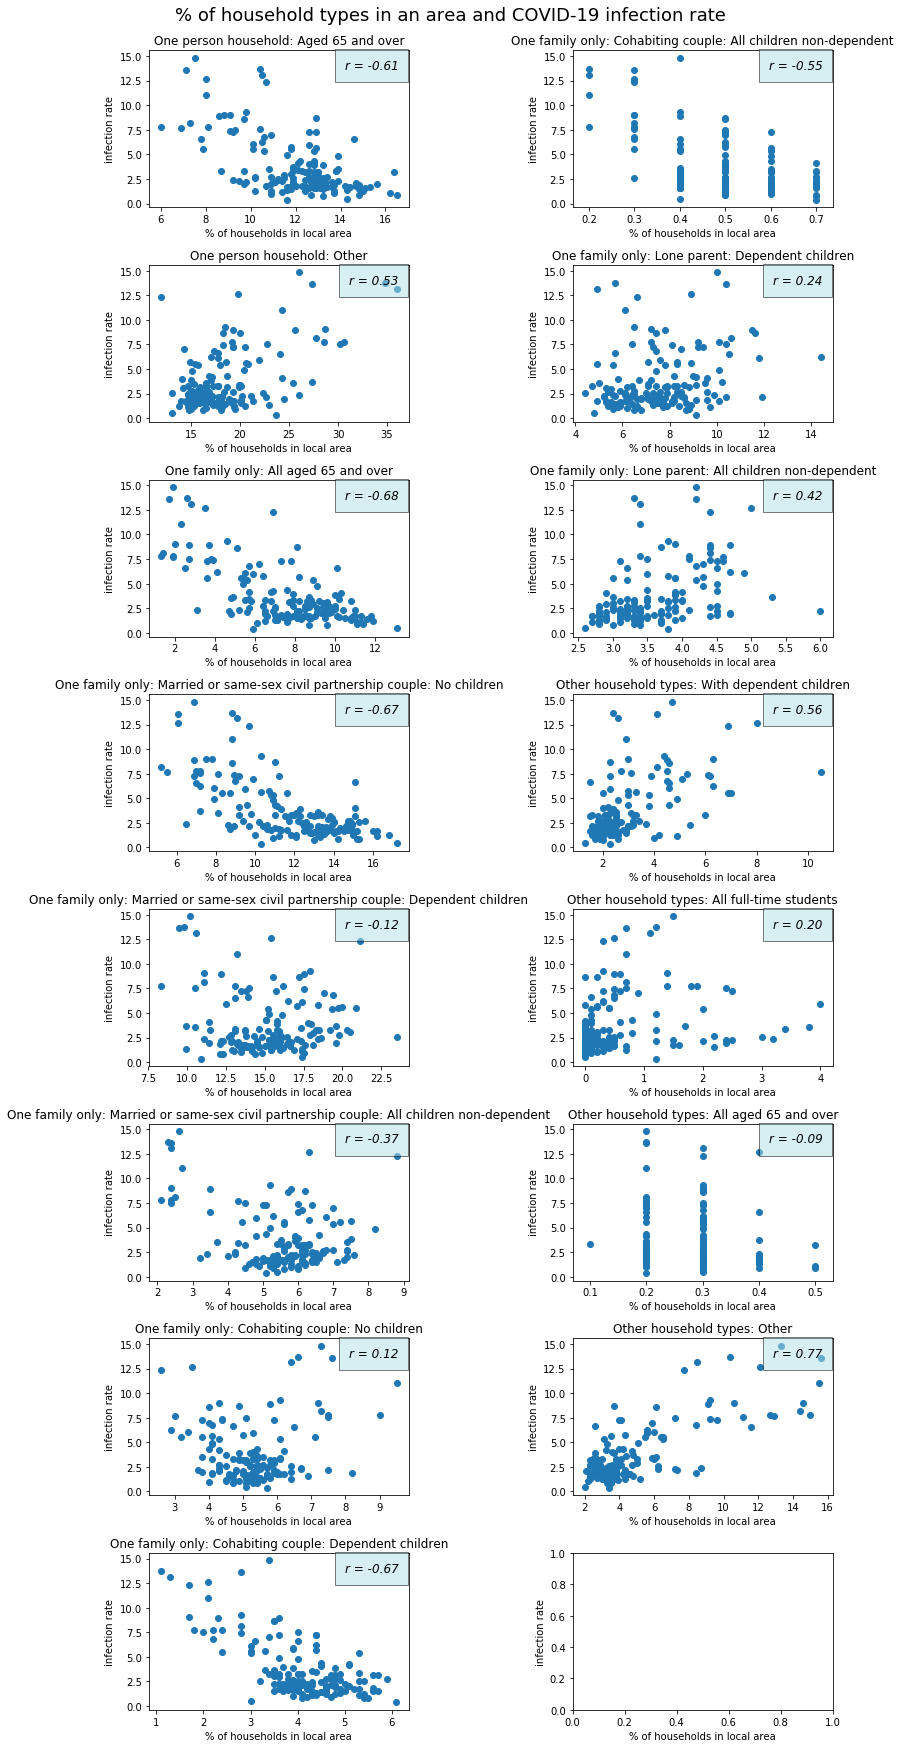

In [12]:

res2a=res2.iloc[:,0]
corrs2=corrs.iloc[:,5:]

fig, axs = plt.subplots(8, 2, figsize = (12,24))
fig.suptitle('% of household types in an area and COVID-19 infection rate',y=1.01,fontsize=18)

for i,col in enumerate(corrs2.columns):
    if i<=7:
        axs[i, 0].scatter(corrs2[col], corrs["inf_rate"])
        axs[i, 0].set_title(str(res2a.index[i]))
        axs[i, 0].annotate("r = {:.2f}".format(res2a[i]), xy=(0.96, 0.86), xycoords='axes fraction', fontsize=12,style='italic',
                horizontalalignment='right', verticalalignment='bottom',bbox={'facecolor': 'powderblue', 'alpha': 0.5, 'pad': 10})
    else:
        axs[i-8, 1].scatter(corrs2[col], corrs["inf_rate"])
        axs[i-8, 1].set_title(str(res2a.index[i]))
        axs[i-8, 1].annotate("r = {:.2f}".format(res2a[i]), xy=(0.96, 0.86), xycoords='axes fraction', fontsize=12,style='italic',
                horizontalalignment='right', verticalalignment='bottom',bbox={'facecolor': 'powderblue', 'alpha': 0.5, 'pad': 10})
for ax in axs.flat:
    ax.set(xlabel='% of households in local area', ylabel='infection rate')
plt.tight_layout()

# Country of origin

In [15]:
df_country=pd.read_csv('country_data.csv')
df_country=df_country.rename(columns={'Area code': 'Area Code'})
df_country.loc[df_country['Area Code'] =='E06000048', 'Area Code'] = "E06000057"
df_country.loc[df_country['Area Code'] =='E06000028', 'Area Code'] = "E06000058"
df_country.loc[df_country['Area Code'] =='E10000009', 'Area Code'] = "E06000059"
df_country.loc[df_country['Area Code'] =='E08000020', 'Area Code'] = "E08000037"

df3=pd.merge(df,df_country,on='Area Code',how="left")
corrs=df3.iloc[:,29:]
ctable=corrs.corr()
res3=ctable.iloc[4:,[0,1,2,3]]

res3.columns=['infection/1000 people','speed of spread to 1/1000 infections','speed of spread 1/1000 to 2/1000 infections','exponential parameter']
res3=res3.round(3)
res3

,infection/1000 people,speed of spread to 1/1000 infections,speed of spread 1/1000 to 2/1000 infections,exponential parameter
England,-0.810,0.525,0.006,-0.090
Northern Ireland,0.145,-0.053,0.123,-0.018
Scotland,-0.164,0.186,0.142,-0.092
Wales,-0.189,0.161,0.289,0.043
United Kingdom not otherwise specified,0.107,-0.140,-0.017,0.011
Ireland,0.713,-0.457,0.015,0.127
Other EU: Member countries in March 2001,0.720,-0.462,0.031,0.096
Other EU: Accession countries April 2001 to March 2011,0.496,-0.302,-0.064,0.071
Other countries,0.813,-0.541,-0.036,0.081


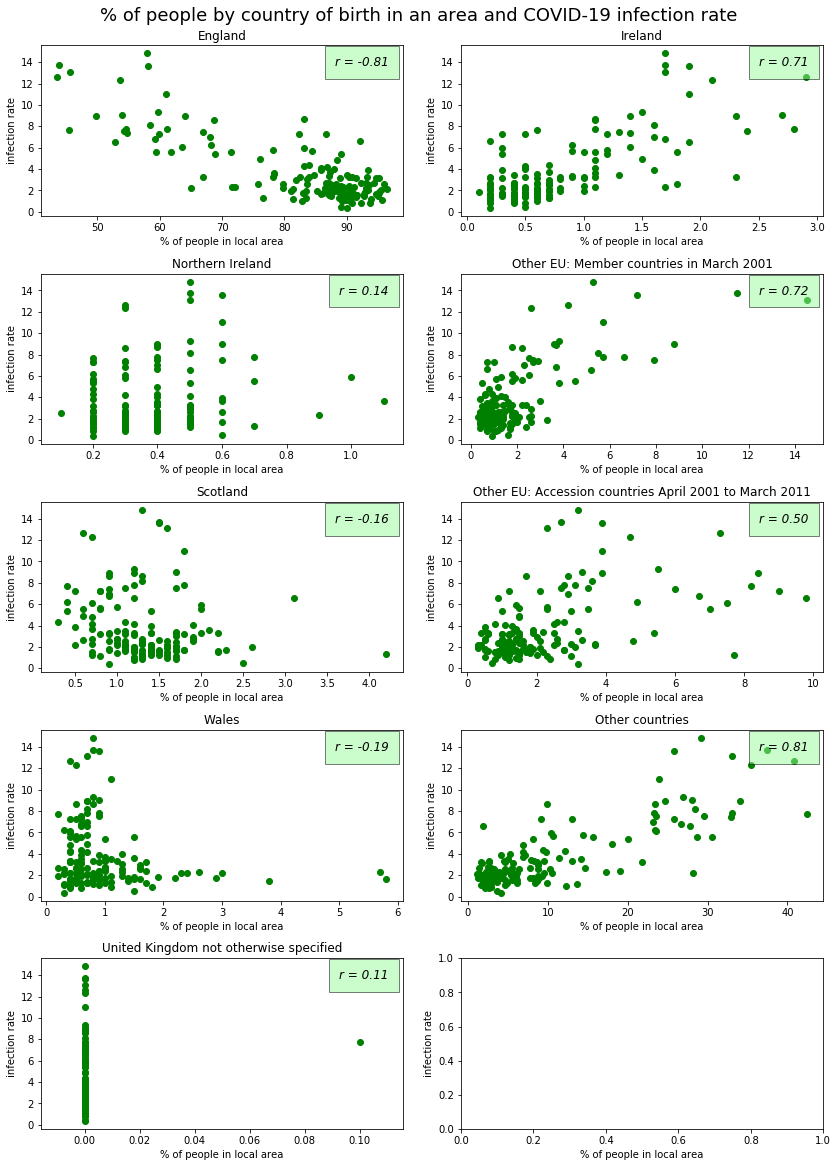

In [17]:

res3a=res3.iloc[:,0]
corrs3=corrs.iloc[:,5:]

fig, axs = plt.subplots(5, 2, figsize = (12,16))
fig.suptitle('% of people by country of birth in an area and COVID-19 infection rate',y=1.01,fontsize=18)

for i,col in enumerate(corrs3.columns):
    if i<=4:
        axs[i, 0].scatter(corrs3[col], corrs["inf_rate"],c='green')
        axs[i, 0].set_title(str(res3a.index[i]))
        axs[i, 0].annotate("r = {:.2f}".format(res3a[i]), xy=(0.96, 0.86), xycoords='axes fraction', fontsize=12,style='italic',
                horizontalalignment='right', verticalalignment='bottom',bbox={'facecolor': 'palegreen', 'alpha': 0.5, 'pad': 10})
    else:
        axs[i-5, 1].scatter(corrs3[col], corrs["inf_rate"],c='green')
        axs[i-5, 1].set_title(str(res3a.index[i]))
        axs[i-5, 1].annotate("r = {:.2f}".format(res3a[i]), xy=(0.96, 0.86), xycoords='axes fraction', fontsize=12,style='italic',
                horizontalalignment='right', verticalalignment='bottom',bbox={'facecolor': 'palegreen', 'alpha': 0.5, 'pad': 10})
for ax in axs.flat:
    ax.set(xlabel='% of people in local area', ylabel='infection rate')
plt.tight_layout()

# Ethnicity

In [19]:
df_eth=pd.read_csv('ethn_data.csv')
df_eth=df_eth.rename(columns={'Area code': 'Area Code'})
df_eth.loc[df_eth['Area Code'] =='E06000048', 'Area Code'] = "E06000057"
df_eth.loc[df_eth['Area Code'] =='E06000028', 'Area Code'] = "E06000058"
df_eth.loc[df_eth['Area Code'] =='E10000009', 'Area Code'] = "E06000059"
df_eth.loc[df_eth['Area Code'] =='E08000020', 'Area Code'] = "E08000037"

df4=pd.merge(df,df_eth,on='Area Code',how="left")
corrs=df4.iloc[:,29:]
ctable=corrs.corr()
res4=ctable.iloc[4:,[0,1,2,3]]

res4.columns=['infection/1000 people','speed of spread to 1/1000 infections','speed of spread 1/1000 to 2/1000 infections','exponential parameter']
res4=res4.round(3)
res4

,infection/1000 people,speed of spread to 1/1000 infections,speed of spread 1/1000 to 2/1000 infections,exponential parameter
White: English/Welsh/Scottish/Northern Irish/British,-0.790,0.531,0.060,-0.078
White: Irish,0.720,-0.459,0.006,0.124
White: Gypsy or Irish Traveller,0.013,-0.017,0.029,0.154
White: Other White,0.747,-0.487,-0.004,0.118
Mixed/multiple ethnic group: White and Black Caribbean,0.567,-0.413,-0.058,0.065
Mixed/multiple ethnic group: White and Black African,0.736,-0.505,-0.020,0.080
Mixed/multiple ethnic group: White and Asian,0.723,-0.505,0.044,0.093
Mixed/multiple ethnic group: Other Mixed,0.827,-0.547,-0.014,0.116
Asian/Asian British: Indian,0.392,-0.280,-0.069,-0.031
Asian/Asian British: Pakistani,0.105,-0.070,-0.096,-0.044


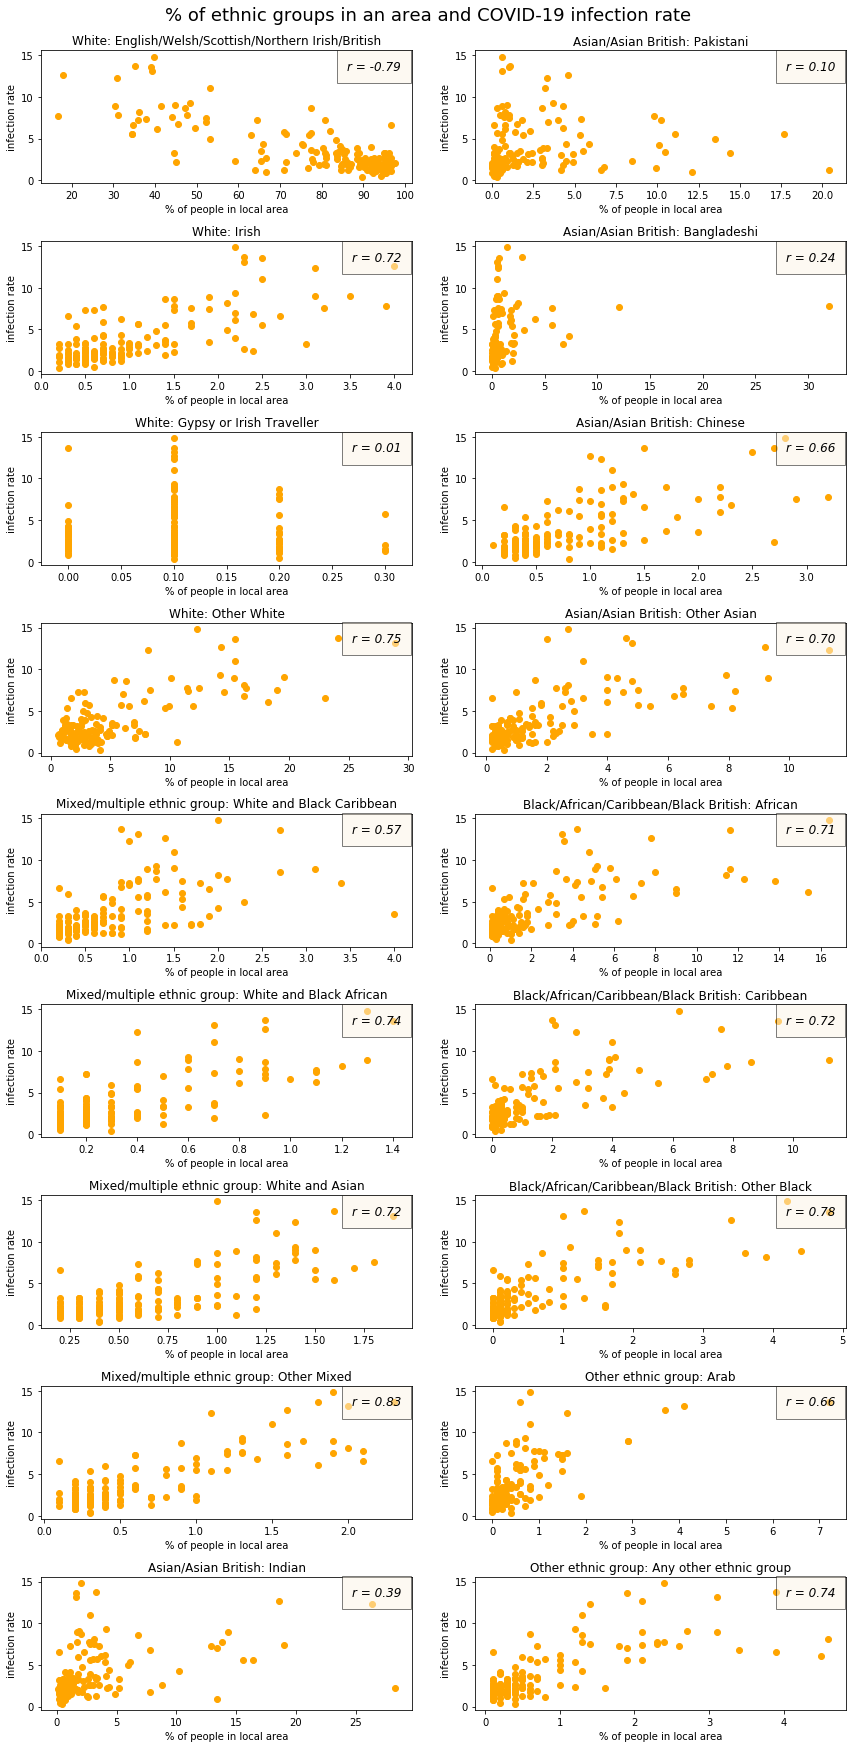

In [20]:

res4a=res4.iloc[:,0]
corrs4=corrs.iloc[:,5:]

fig, axs = plt.subplots(9, 2, figsize = (12,24))
fig.suptitle('% of ethnic groups in an area and COVID-19 infection rate',y=1.01,fontsize=18)

for i,col in enumerate(corrs4.columns):
    if i<=8:
        axs[i, 0].scatter(corrs4[col], corrs["inf_rate"],c='orange')
        axs[i, 0].set_title(str(res4a.index[i]))
        axs[i, 0].annotate("r = {:.2f}".format(res4a[i]), xy=(0.97, 0.83), xycoords='axes fraction', fontsize=12,style='italic',
                horizontalalignment='right', verticalalignment='bottom',bbox={'facecolor': 'oldlace', 'alpha': 0.5, 'pad': 10})
    else:
        axs[i-9, 1].scatter(corrs4[col], corrs["inf_rate"],c='orange')
        axs[i-9, 1].set_title(str(res4a.index[i]))
        axs[i-9, 1].annotate("r = {:.2f}".format(res4a[i]), xy=(0.97, 0.83), xycoords='axes fraction', fontsize=12,style='italic',
                horizontalalignment='right', verticalalignment='bottom',bbox={'facecolor': 'oldlace', 'alpha': 0.5, 'pad': 10})
for ax in axs.flat:
    ax.set(xlabel='% of people in local area', ylabel='infection rate')
plt.tight_layout()

# Income, population and population density

In [23]:

df_inc=pd.read_csv('income_data.csv')
df_inc=df_inc.rename(columns={'LAU1 code': 'Area Code'})

df5=pd.merge(df,df_inc,on='Area Code',how="left")

df_den=pd.read_csv('density.csv')
df_den=df_den.rename(columns={'Area code': 'Area Code'})
df_den.loc[df_den['Area Code'] =='E06000048', 'Area Code'] = "E06000057"
df_den.loc[df_den['Area Code'] =='E06000028', 'Area Code'] = "E06000058"
df_den.loc[df_den['Area Code'] =='E10000009', 'Area Code'] = "E06000059"
df_den.loc[df_den['Area Code'] =='E08000020', 'Area Code'] = "E08000037"

df5=pd.merge(df5,df_den,on='Area Code',how="left")

corrs=df5.iloc[:,28:]
ctable=corrs.corr()
res5=ctable.iloc[[0,5,6],[1,2,3,4]]

res5.columns=['infection/1000 people','speed of spread to 1/1000 infections','speed of spread 1/1000 to 2/1000 infections','exponential parameter']
res5=res5.round(3)
res5

,infection/1000 people,speed of spread to 1/1000 infections,speed of spread 1/1000 to 2/1000 infections,exponential parameter
population,-0.139,0.355,0.019,0.176
2016,0.637,-0.450,0.084,0.428
Density,0.780,-0.560,-0.047,0.052


# Homeless deaths in area

In [25]:

df_hl=pd.read_csv('homeless_data.csv')
df_hl=df_hl.rename(columns={'Code': 'Area Code'})
df_hl=df_hl.rename(columns={'5 years combined': 'hl_death_rate'})
df_hl['hl_death_rate']=df_hl['hl_death_rate'].replace(' - ','', regex=True)
df_hl['hl_death_rate'] = df_hl['hl_death_rate'].apply(pd.to_numeric, errors='coerce')
df_hl=df_hl.iloc[:,0:2]

df6=pd.merge(df,df_hl,on='Area Code',how="left")
corrs=df6.iloc[:,29:]
ctable=corrs.corr()
res6=ctable.iloc[4:,[0,1,2,3]]


res6.columns=['infection/1000 people','speed of spread to 1/1000 infections','speed of spread 1/1000 to 2/1000 infections','exponential parameter']
res6=res6.round(3)
res6

,infection/1000 people,speed of spread to 1/1000 infections,speed of spread 1/1000 to 2/1000 infections,exponential parameter
hl_death_rate,0.224,-0.209,0.069,0.028


C:\Users\peter\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


<function matplotlib.pyplot.show(*args, **kw)>

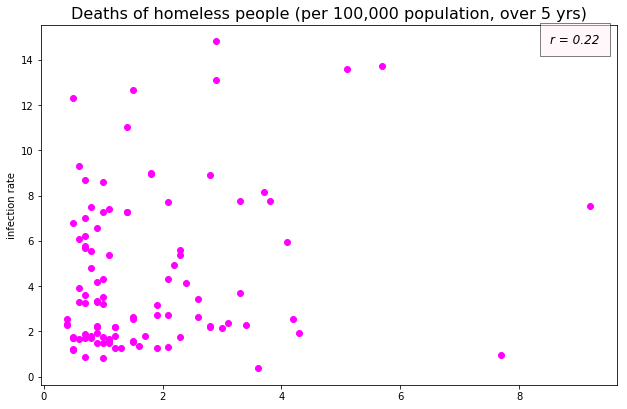

In [26]:

res6a=np.asscalar(res6.iloc[:,0])
corrs6=corrs.iloc[:,[4]]

fig = plt.figure(figsize = (8,5))
ax=fig.add_axes([0,0,1,1])

ax.scatter(corrs6['hl_death_rate'], corrs["inf_rate"],c='magenta')
ax.set_title('Deaths of homeless people (per 100,000 population, over 5 yrs)', fontsize=16)
ax.annotate("r = {:.2f}".format(res6a), xy=(0.97, 0.94), xycoords='axes fraction', fontsize=12,style='italic',
        horizontalalignment='right', verticalalignment='bottom',bbox={'facecolor': 'lavenderblush', 'alpha': 0.5, 'pad': 10})
ax.set(xlabel='', ylabel='infection rate')

    
plt.tight_layout()
plt.show

# Business size

In [27]:
df_bs=pd.read_csv('business_data.csv')
df_bs=df_bs.rename(columns={'Unnamed: 0': 'Area Code'})
df_bs = df_bs.replace(',','', regex=True)
columns=df_bs.columns
columns=columns[1:]
df_bs[columns] = df_bs[columns].apply(pd.to_numeric, errors='coerce')

columns=columns[0:-1]

df_bs2=df_bs[columns].div(df_bs['Total'], axis=0)
df_bs2=pd.concat([df_bs['Area Code'],df_bs2], axis=1)

df7=pd.merge(df,df_bs2,on='Area Code',how="left")
corrs=df7.iloc[:,29:]
ctable=corrs.corr()
res7=ctable.iloc[4:,[0,1,2,3]]

res7.columns=['infection/1000 people','speed of spread to 1/1000 infections','speed of spread 1/1000 to 2/1000 infections','exponential parameter']
res7=res7.round(3)
res7

,infection/1000 people,speed of spread to 1/1000 infections,speed of spread 1/1000 to 2/1000 infections,exponential parameter
s0-4,0.471,-0.337,0.077,0.147
s05-09,-0.522,0.408,-0.068,-0.104
s10-19,-0.374,0.283,-0.063,-0.164
s20-49,-0.408,0.256,-0.062,-0.156
s50-99,-0.249,0.078,-0.110,-0.168
s100-249,-0.242,0.056,-0.112,-0.138
s250+,-0.116,-0.004,-0.040,-0.121


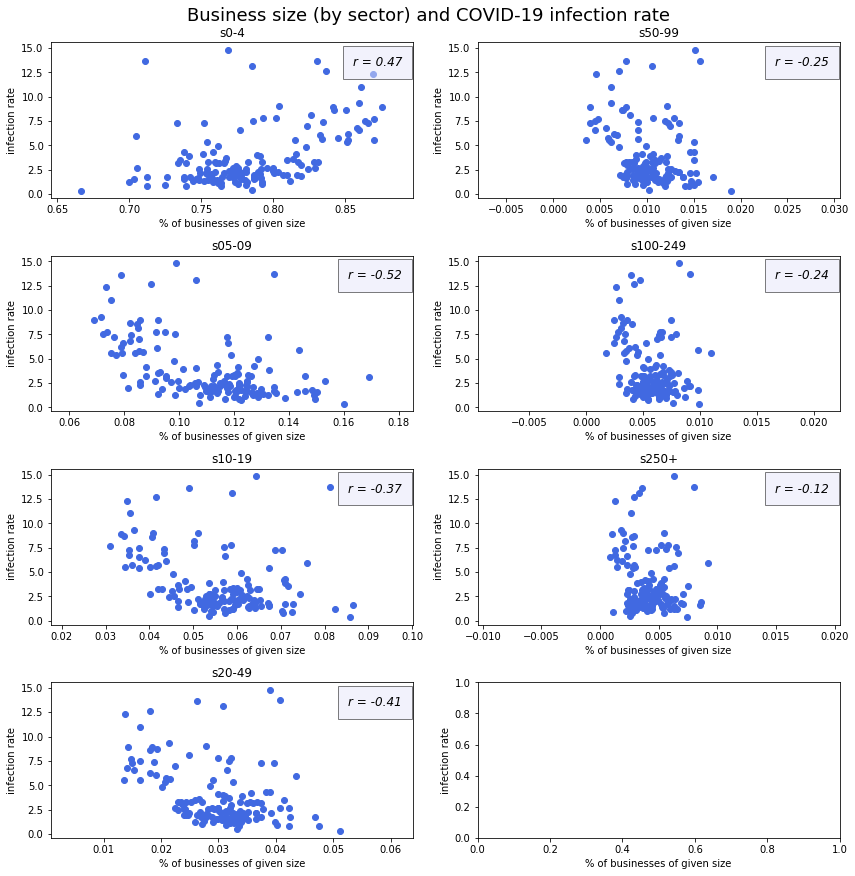

In [28]:
res7a=res7.iloc[:,0]
corrs7=corrs.iloc[:,4:]

fig, axs = plt.subplots(4, 2, figsize = (12,12))
fig.suptitle('Business size (by sector) and COVID-19 infection rate',y=1.01,fontsize=18)

for i,col in enumerate(corrs7.columns):
    if i<=3:
        axs[i, 0].scatter(corrs7[col], corrs["inf_rate"],c='royalblue')
        axs[i, 0].set_title(str(res7a.index[i]))
        axs[i, 0].annotate("r = {:.2f}".format(res7a[i]), xy=(0.97, 0.83), xycoords='axes fraction', fontsize=12,style='italic',
                horizontalalignment='right', verticalalignment='bottom',bbox={'facecolor': 'lavender', 'alpha': 0.5, 'pad': 10})
    else:
        axs[i-4, 1].scatter(corrs7[col], corrs["inf_rate"],c='royalblue')
        axs[i-4, 1].set_title(str(res7a.index[i]))
        axs[i-4, 1].annotate("r = {:.2f}".format(res7a[i]), xy=(0.97, 0.83), xycoords='axes fraction', fontsize=12,style='italic',
                horizontalalignment='right', verticalalignment='bottom',bbox={'facecolor': 'lavender', 'alpha': 0.5, 'pad': 10})
for ax in axs.flat:
    ax.set(xlabel='% of businesses of given size', ylabel='infection rate')
plt.tight_layout()



# Sector of business

In [30]:
df_bsi=pd.read_csv('business_i_data.csv')
df_bsi=df_bsi.rename(columns={'Unnamed: 0': 'Area Code'})
df_bsi = df_bsi.replace(',','', regex=True)
columns=df_bsi.columns
columns=columns[1:]
df_bsi[columns] = df_bsi[columns].apply(pd.to_numeric, errors='coerce')
columns=columns[0:-1]

df_bsi2=df_bsi[columns].div(df_bsi['Total'], axis=0)
df_bsi2=pd.concat([df_bsi['Area Code'],df_bsi2], axis=1)

df8=pd.merge(df,df_bsi2,on='Area Code',how="left")
corrs=df8.iloc[:,29:]
ctable=corrs.corr()
res8=ctable.iloc[4:,[0,1,2,3]]
#res8.reset_index(level=0, inplace=True)

res8.columns=['infection/1000 people','speed of spread to 1/1000 infections','speed of spread 1/1000 to 2/1000 infections','exponential parameter']
res8=res8.round(3)
res8

,infection/1000 people,speed of spread to 1/1000 infections,speed of spread 1/1000 to 2/1000 infections,exponential parameter
"01-03 : Agriculture, forestry & fishing",-0.355,0.371,0.017,0.052
05-39 : Production,-0.554,0.292,-0.161,-0.097
41-43 : Construction,-0.173,0.095,-0.044,0.043
45 : Motor trades,-0.655,0.439,-0.160,-0.130
46 : Wholesale,-0.036,-0.053,-0.039,0.028
47 : Retail,-0.174,0.034,-0.032,-0.170
49-53 : Transport & Storage (inc. postal),-0.281,0.135,-0.145,-0.035
55-56 : Accommodation & food services,-0.213,0.179,-0.115,-0.160
58-63 : Information & communication,0.576,-0.379,0.207,0.110
64-66 : Finance & insurance,0.072,-0.089,0.074,-0.080


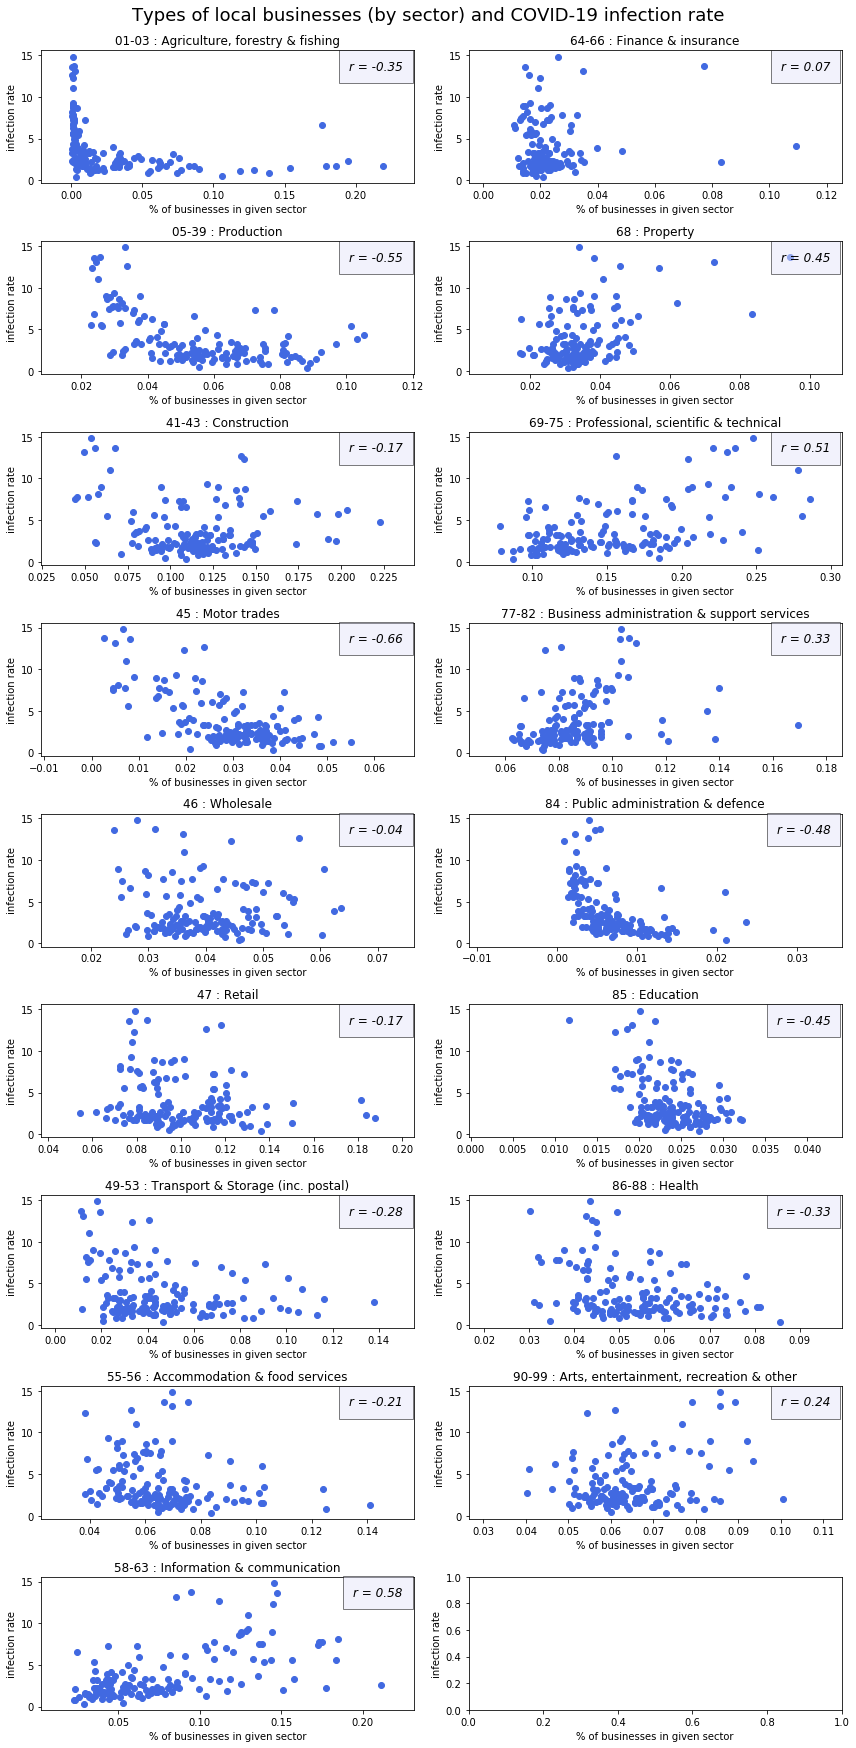

In [31]:
res8a=res8.iloc[:,0]
corrs8=corrs.iloc[:,4:]

fig, axs = plt.subplots(9, 2, figsize = (12,24))
fig.suptitle('Types of local businesses (by sector) and COVID-19 infection rate',y=1.01,fontsize=18)

for i,col in enumerate(corrs8.columns):
    if i<=8:
        axs[i, 0].scatter(corrs8[col], corrs["inf_rate"],c='royalblue')
        axs[i, 0].set_title(str(res8a.index[i]))
        axs[i, 0].annotate("r = {:.2f}".format(res8a[i]), xy=(0.97, 0.83), xycoords='axes fraction', fontsize=12,style='italic',
                horizontalalignment='right', verticalalignment='bottom',bbox={'facecolor': 'lavender', 'alpha': 0.5, 'pad': 10})
    else:
        axs[i-9, 1].scatter(corrs8[col], corrs["inf_rate"],c='royalblue')
        axs[i-9, 1].set_title(str(res8a.index[i]))
        axs[i-9, 1].annotate("r = {:.2f}".format(res8a[i]), xy=(0.97, 0.83), xycoords='axes fraction', fontsize=12,style='italic',
                horizontalalignment='right', verticalalignment='bottom',bbox={'facecolor': 'lavender', 'alpha': 0.5, 'pad': 10})
for ax in axs.flat:
    ax.set(xlabel='% of businesses in given sector', ylabel='infection rate')
plt.tight_layout()

# crime figures

In [33]:
df_crime=pd.read_csv('crime_data.csv')
df_crime=df_crime.rename(columns={'ONS Code': 'CSP code'})
df_crime=df_crime.rename(columns={'Rolling year total number of offences': 'offences'})
df_crime=df_crime.rename(columns={'12 months ending': 'time'})
df_codes=pd.read_csv('area_codes.csv')
df_codes=df_codes.rename(columns={'LAD18CD': 'Area Code'})
df_codes=df_codes.rename(columns={'CSP18CD': 'CSP code'})
df_codes=df_codes[['CSP code','Area Code']]
df_crime=pd.merge(df_crime,df_codes,on='CSP code',how="left")


df_crime2=df_crime.groupby(['Area Code','Offence']).agg({'offences':'sum'}).unstack()
df_crime2.reset_index(level=0, inplace=True)

df9=pd.merge(df,df_crime2,on='Area Code',how="left")

columns=df9.columns
columns=columns[33:]
df9=df9[columns].div((df9['population']/1000), axis=0) # dividing by population

df9a=pd.concat([df[['Area Code','inf_rate','toone','onetotwo','exp_para1']],df9], axis=1)

corrs=df9a
ctable=corrs.corr()
res9=ctable.iloc[3:,[0,1,2,3]]

res9.columns=['infection/1000 people','speed of spread to 1/1000 infections','speed of spread 1/1000 to 2/1000 infections','exponential parameter']
res9=res9.round(3)
res9

,infection/1000 people,speed of spread to 1/1000 infections,speed of spread 1/1000 to 2/1000 infections,exponential parameter
exp_para1,0.152,-0.122,0.075,1.000
"(offences, All other theft offences)",0.449,-0.297,-0.039,0.147
"(offences, Bicycle theft)",0.299,-0.180,0.054,0.084
"(offences, Criminal damage and arson)",-0.474,0.305,-0.150,-0.509
"(offences, Death or serious injury caused by illegal driving)",-0.245,0.284,-0.109,-0.205
"(offences, Domestic burglary)",-0.155,0.262,-0.121,-0.130
"(offences, Drug offences)",0.614,-0.392,-0.119,0.254
"(offences, Homicide)",0.195,-0.185,0.011,0.085
"(offences, Miscellaneous crimes against society)",-0.364,0.285,-0.076,-0.343
"(offences, Non-domestic burglary)",-0.171,0.089,-0.121,-0.215


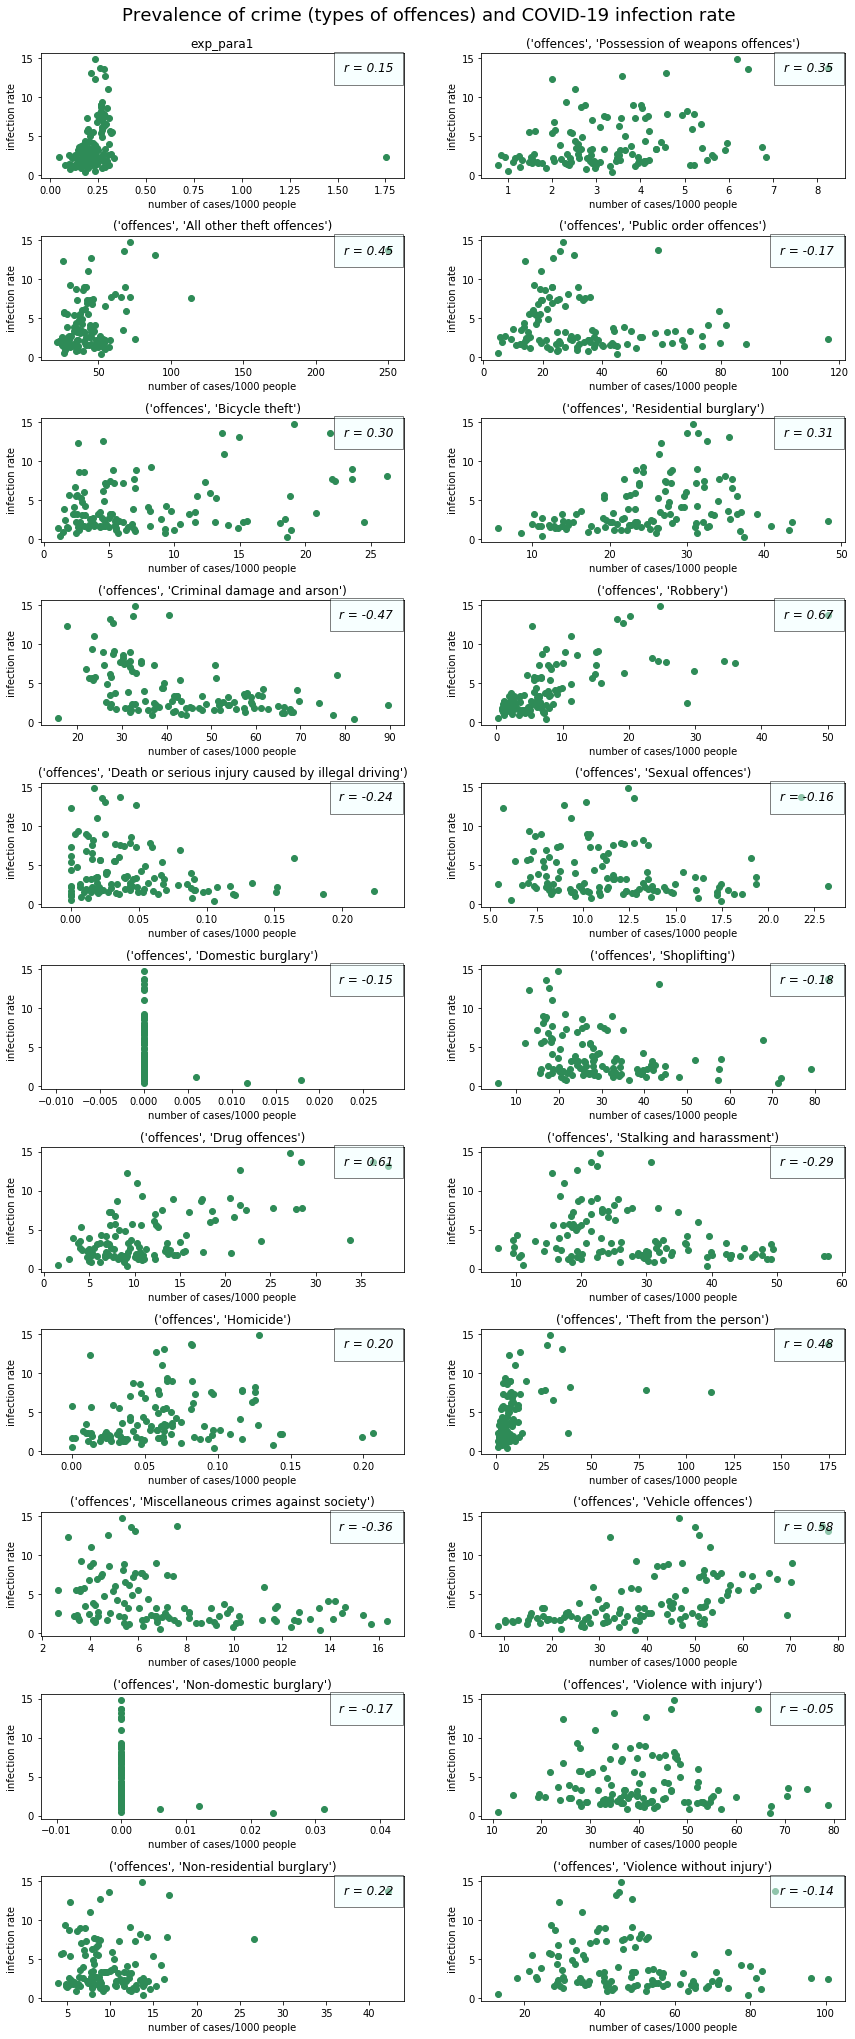

In [34]:
res9a=res9.iloc[:,0]
corrs9=corrs.iloc[:,4:]

fig, axs = plt.subplots(11, 2, figsize = (12,28))
fig.suptitle('Prevalence of crime (types of offences) and COVID-19 infection rate',y=1.01,fontsize=18)

for i,col in enumerate(corrs9.columns):
    if i<=10:
        axs[i, 0].scatter(corrs9[col], corrs["inf_rate"],c='seagreen')
        axs[i, 0].set_title(str(res9a.index[i]))
        axs[i, 0].annotate("r = {:.2f}".format(res9a[i]), xy=(0.97, 0.83), xycoords='axes fraction', fontsize=12,style='italic',
                horizontalalignment='right', verticalalignment='bottom',bbox={'facecolor': 'azure', 'alpha': 0.5, 'pad': 10})
    else:
        axs[i-11, 1].scatter(corrs9[col], corrs["inf_rate"],c='seagreen')
        axs[i-11, 1].set_title(str(res9a.index[i]))
        axs[i-11, 1].annotate("r = {:.2f}".format(res9a[i]), xy=(0.97, 0.83), xycoords='axes fraction', fontsize=12,style='italic',
                horizontalalignment='right', verticalalignment='bottom',bbox={'facecolor': 'azure', 'alpha': 0.5, 'pad': 10})
for ax in axs.flat:
    ax.set(xlabel='number of cases/1000 people', ylabel='infection rate')
plt.tight_layout()

# crime severity index

In [35]:
df_crime_s=pd.read_csv('crime_severity.csv')
df_crime_s=df_crime_s.rename(columns={'Code': 'CSP code'})
df_codes=pd.read_csv('area_codes.csv')
df_codes=df_codes.rename(columns={'LAD18CD': 'Area Code'})
df_codes=df_codes.rename(columns={'CSP18CD': 'CSP code'})
df_codes=df_codes[['CSP code','Area Code']]
df_crime_s=pd.merge(df_crime_s,df_codes,on='CSP code',how="left")
df_crime_s=df_crime_s.iloc[:,-3:]
columns=df_crime_s.columns[0:2]
df_crime_s[columns] = df_crime_s[columns].apply(pd.to_numeric, errors='coerce')

df10=pd.merge(df,df_crime_s,on='Area Code',how="left")

corrs=df10.iloc[:,28:]
ctable=corrs.corr()
res10=ctable.iloc[5:,[0,1,2,3]]
res10.columns=['infection/1000 people','speed of spread to 1/1000 infections','1/1000 to 2/2000','exponential parameter']
res10=res10.round(3)
res10

,infection/1000 people,speed of spread to 1/1000 infections,1/1000 to 2/2000,exponential parameter
offence rate (per 1000ppl),0.011,0.042,-0.029,-0.047
crime severity index (2018/19),0.050,0.076,-0.051,-0.046


# health status

In [36]:
df_health=pd.read_csv('health_status.csv')
df_health.columns[0]
df_health=df_health.rename(columns={'Unnamed: 0': 'Area Code'})
df_health['Area Code']=df_health['Area Code'].apply(lambda x: str(x).split()[0])
df_health=df_health.iloc[:,[0,7,8,9,10,11]]
columns=df_health.columns
columns=columns[1:]
df_health[columns] = df_health[columns].apply(pd.to_numeric, errors='coerce')


df11=pd.merge(df,df_health,on='Area Code',how="left")
corrs=df11.iloc[:,29:]
ctable=corrs.corr()
res11=ctable.iloc[4:,[0,1,2,3]]

res11.columns=['infection/1000 people','speed of spread to 1/1000 infections','1/1000 to 2/2000','exponential parameter']
res11=res11.round(3)
res11

,infection/1000 people,speed of spread to 1/1000 infections,1/1000 to 2/2000,exponential parameter
1 Very good (%),0.182,0.135,-0.045,0.157
2 Good (%),0.094,0.191,-0.029,0.106
3 Fair (%),-0.062,0.305,-0.105,-0.027
4 Bad (%),-0.042,0.213,-0.103,-0.047
5 Very Bad (%),-0.021,0.186,-0.157,0.065


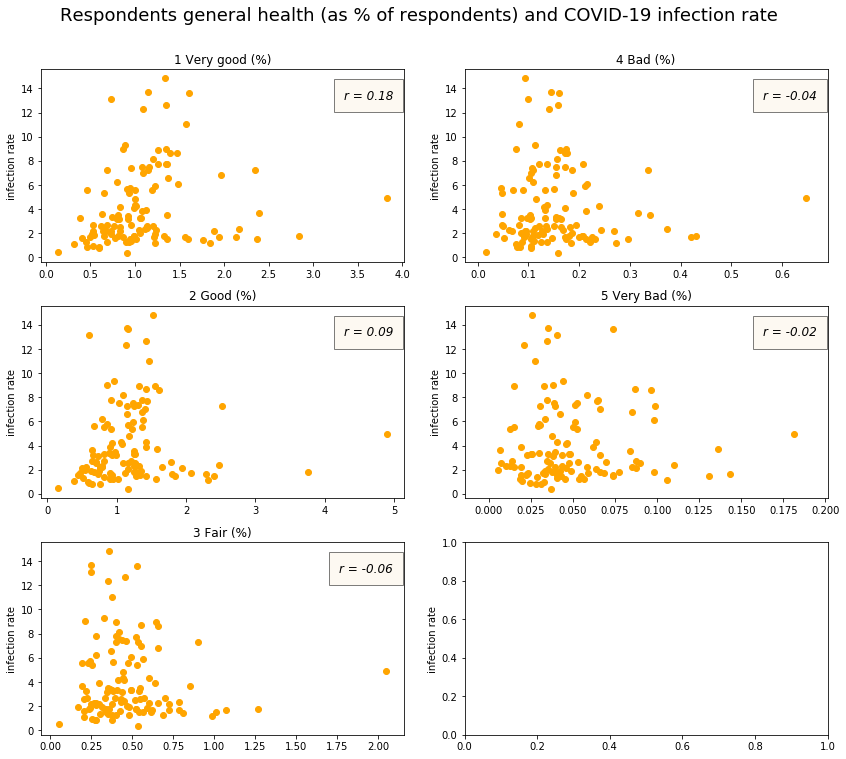

In [37]:
res11a=res11.iloc[:,0]
corrs11=corrs.iloc[:,4:]

fig, axs = plt.subplots(3, 2, figsize = (12,10))
fig.suptitle('Respondents general health (as % of respondents) and COVID-19 infection rate',y=1.05,fontsize=18)

for i,col in enumerate(corrs11.columns):
    if i<=2:
        axs[i, 0].scatter(corrs11[col], corrs["inf_rate"],c='orange')
        axs[i, 0].set_title(str(res11a.index[i]))
        axs[i, 0].annotate("r = {:.2f}".format(res11a[i]), xy=(0.97, 0.83), xycoords='axes fraction', fontsize=12,style='italic',
                horizontalalignment='right', verticalalignment='bottom',bbox={'facecolor': 'oldlace', 'alpha': 0.5, 'pad': 10})
    else:
        axs[i-3, 1].scatter(corrs11[col], corrs["inf_rate"],c='orange')
        axs[i-3, 1].set_title(str(res11a.index[i]))
        axs[i-3, 1].annotate("r = {:.2f}".format(res11a[i]), xy=(0.97, 0.83), xycoords='axes fraction', fontsize=12,style='italic',
                horizontalalignment='right', verticalalignment='bottom',bbox={'facecolor': 'oldlace', 'alpha': 0.5, 'pad': 10})
for ax in axs.flat:
    ax.set(xlabel='', ylabel='infection rate')
plt.tight_layout()

# life expectancy

In [38]:
df_le=pd.read_csv('le_data.csv')
df_le=df_le.rename(columns={'Area Codes': 'Area Code'})
df_le=df_le.iloc[:,:5]

df12=pd.merge(df,df_le,on='Area Code',how="left")
corrs=df12.iloc[:,29:]
ctable=corrs.corr()
res12=ctable.iloc[4:,[0,1,2,3]]

res12.columns=['infection/1000 people','speed of spread to 1/1000 infections','1/1000 to 2/1000','exponential parameter']
res12=res12.round(3)
res12

,infection/1000 people,speed of spread to 1/1000 infections,1/1000 to 2/1000,exponential parameter
LE at birth (male),0.350,-0.160,0.209,0.203
LE at birth (female),0.432,-0.236,0.169,0.225
LE at 65 (male),0.377,-0.166,0.154,0.176
LE at 65 (female),0.451,-0.252,0.143,0.207


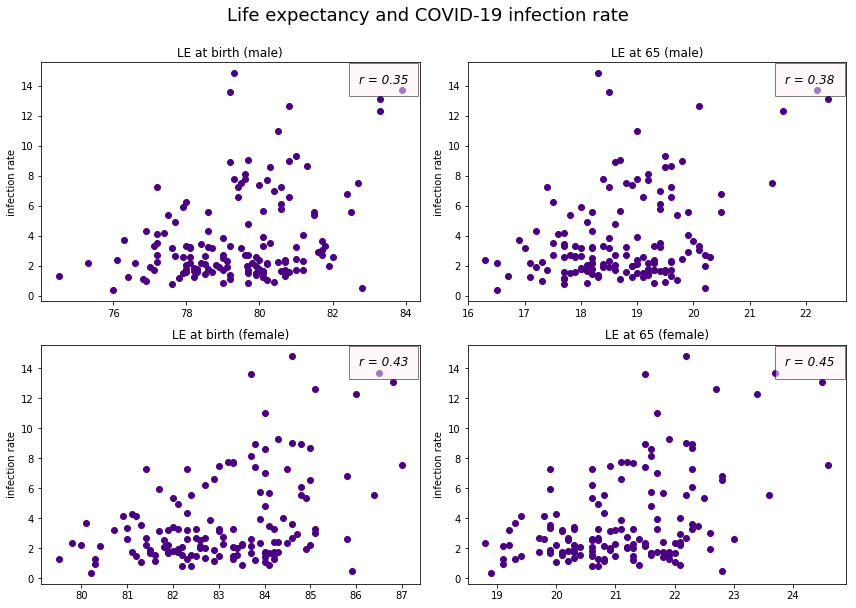

In [39]:
res12a=res12.iloc[:,0]
corrs12=corrs.iloc[:,4:]

fig, axs = plt.subplots(2, 2, figsize = (12,8))
fig.suptitle('Life expectancy and COVID-19 infection rate',y=1.05,fontsize=18)

for i,col in enumerate(corrs12.columns):
    if i<=1:
        axs[i, 0].scatter(corrs12[col], corrs["inf_rate"],c='indigo')
        axs[i, 0].set_title(str(res12a.index[i]))
        axs[i, 0].annotate("r = {:.2f}".format(res12a[i]), xy=(0.97, 0.90), xycoords='axes fraction', fontsize=12,style='italic',
                horizontalalignment='right', verticalalignment='bottom',bbox={'facecolor': 'lavenderblush', 'alpha': 0.5, 'pad': 10})
    else:
        axs[i-2, 1].scatter(corrs12[col], corrs["inf_rate"],c='indigo')
        axs[i-2, 1].set_title(str(res12a.index[i]))
        axs[i-2, 1].annotate("r = {:.2f}".format(res12a[i]), xy=(0.97, 0.90), xycoords='axes fraction', fontsize=12,style='italic',
                horizontalalignment='right', verticalalignment='bottom',bbox={'facecolor': 'lavenderblush', 'alpha': 0.5, 'pad': 10})
for ax in axs.flat:
    ax.set(xlabel='', ylabel='infection rate')
plt.tight_layout()